<a href="https://colab.research.google.com/github/brunamulinari/TechLabsProject_PsiData/blob/main/dados_Brasil/Pysus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
__author__ = 'Guilherme Cardoso de Vargas'
__version__ = 1.0
__maintainer__ = 'Guilherme Cardoso de Vargas'
__email__ = 'vargas93626@gmail.com'
__status__ = 'Development'

#**Pacotes necessários para as análises**

Para realizar a análises são necessários alguns pacotes





In [ ]:
!pip install PySUS #APi com dados do dataSUS

'''Documentação da API PySUS
https://pysus.readthedocs.io/_/downloads/en/latest/pdf/ '''

#Pacote necessário para a execução da API PySUS e análises
!pip install pandas
!pip install matplotlib
!pip install geopandas 
!pip install plotly


#**Download dos dados do Sistema de Informações sobre Mortalidade-SIM**

O DATASUS possuí vários seguimentos de notificação, como o Sistema de Informação de Nascidos Vivos (SINASC) e Sistema de informações de Mortalidade (SIM). 

O Sistema de Informações sobre Mortalidade (SIM) foi criado pelo DATASUS para a obtenção regular de dados sobre mortalidade no país. A partir da criação do SIM foi possível a captação de dados sobre mortalidade, de forma abrangente, para subsidiar as diversas esferas de gestão na saúde pública. Com base nessas informações é possível realizar análises de situação, planejamento e avaliação das ações e programas na área.

In [ ]:
from pysus.online_data.SIM import download
from pysus.online_data import SIM
from pysus.preprocessing.decoders import decodifica_idade_SIM, translate_variables_SIM
import datetime
import pandas as pd

states = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']
years = [2017,2018,2019]

banco={}

# Download dos dados
for y in years:
  for s in states:
    banco[s] = translate_variables_SIM(download(state=s, year=y)) 
    print(f'Download dos dados do estado de {s} no ano de {y}')
#Em decorrência da falta de memoria RAM, optei por gerar um csv para cada ANO com todos os Estados.
#Está estapa pode ser realizada sem transformar os arquivos em csv.
  estados=pd.concat({ k: pd.DataFrame.from_dict(v) for k, v in banco.items() }, axis=0).reset_index()
  estados['ANO'] = y
  estados.to_csv(f'/content/drive/MyDrive/DataSUS/{y}')

#**Gerando um arquivo único com os dados dos anos de 2017 a 2019**


Como comentando anteriormente, devido a falta de memória RAM, os dados baixados via API foram transformados em 3 arquivos CSV, respectivo ao seu ano.

Para trabalharmos melhor com esses arquivos iremos gerar um arquivo só com o 3 anos.

In [ ]:
from os import listdir
import pandas as pd

path ='/content/drive/MyDrive/DataSUS/'

df = pd.concat([pd.read_csv(path+item)for item in listdir(path)])
df.to_csv(path+'Dados(2017-2019)'+'.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (71) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (70) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (69) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#**Tratamento de dados**

Tratamento e padronização de dados, etapa necessária para as análises e construção do modelo de Reregção Linear.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/DataSUS/Dados(2017-2019).csv')
df.shape

In [ ]:
df.head(1)

In [ ]:
df = df.rename(columns={'level_0': 'ESTADO'})
df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1','level_1'])
df.head()

Colunas presentes nos dados

In [ ]:
df.columns

**Filtrando colunas de interesse**

Principais Colunas de interesse:

    IDADE_ANOS
    ANO
    ESTADO
    CIRCOBITO: circunstância do óbito. 1 : Acidente, 2 : Suicídio, 3 : Homicídio, 4 : Outro, 0;5;6;7;8;9 : NA.
    DTOBITO: data do óbito.
    DTNASC: data de nascimento.
    SEXO: sexo. 1 : Masculino, 2 : Feminino, 0;9 : NA.
    RACACOR: raça. 1 : Branca, 2 : Preta, 3 : Amarela, 4 : Parda, 5 : Indígena, 0;6;7;8;9 : NA.
    ESTCIV: estado civil. 1 : Solteiro, 2 : Casado, 3 : Viúvo, 4 : Separado judicialmente, 5 : União consensual, 0;6;7;8;9 : NA.
    ESC: escolaridade. 1 : Nenhuma, 2: 1 a 3 anos, 3 : 4 a 7 anos, 4 : 8 a 11 anos, 5 : 12 e mais, 8 : De 9 a 11 anos, 0;6;7;9;A : NA. 
    LOCOCOR: Local de ocorrência do óbito. 1 : Hospital, 2 : Outro estabelecimento de saúde, 3 : Domicílio, 4 : Via pública, 5 : Outros, 9 : NA.
    ASSISTMED: Assistência médica. 1 : Sim, 2 : Não, 9 : NA.
    CAUSABAS: Causa básica do óbito. Código CID-10.
    CAUSABAS_O: Causa básica do óbito. Código CID-10.
    CODMUNRES: MUNICIPIOS.

In [ ]:
stay = ['CIRCOBITO', "DTOBITO", "DTNASC","RACACOR",'SEXO',"ESTCIV","LOCOCOR","ESC","ANO", "ESTADO", "IDADE_ANOS", 'ASSISTMED', 'CAUSABAS', 'CAUSABAS_O','CODMUNRES']

for i in df.columns:
  if i not in stay:
    df = df.drop(columns=i)


In [ ]:
df.shape

In [ ]:
df.head()

**Removendo dados com valores nulos**

Removemos os dados nulos para não interferirem nas estatisticas

In [ ]:
df.isnull().sum()

In [ ]:
df = df.dropna(axis=0)

**3.526.675** Casos estão sem CIRCOBITO, isto pode prejudicar as análises estatisticas, então optei por remover esses valores nulos e de outras colunas também.

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

Mais de 310 mil dados foram obtidos com diferentes tipos de óbitos registrados.

In [ ]:
df.describe()

In [ ]:
df.info()

**Filtrando os Casos de Suicídio pela CID-10**

Para separar apenas os casos de suicídio, vamos filtrar os dados seguindo a mesma metodologia empregada por [ Lovisi e colaboradores (2009)](https://www.scielo.br/pdf/rbp/v31s2/v31s2a07.pdf). Vamos filtrar os casos de óbitos tendo como base a Classificação Internacional de Doenças (CID-10), considerando as causas básicas de óbito que variam na CID-10 entre X-60 e X-84 (lesões autoprovocadas intencionalmente).

Na coluna **CUSABAS/CAUSABAS_O** a classificação CID-10 está presente.

A CID-10(Classificação Estatística Internacional de Doenças e Problemas Relacionados com a Saúde) determina a classificação e codificação das doenças e uma ampla variedade de sinais, sintomas, achados anormais, denúncias, circunstâncias sociais e causas externas de danos e/ou doença.

"No banco de dados do SIM, os óbitos por CMD investigados são informados em campo de variável denominado ‘TTPOS’, e as causas básicas dos óbitos são apresentadas de duas maneiras: a original (campo de variável ‘CAUSABAS_O’), referente à causa básica registrada no momento do óbito, no campo 40/Bloco V da DO original; e a causa básica final (campo de variável ‘CAUSABAS’), referente à causa determinada após a investigação do óbito" [(CUNHA et al, 2017)](https://doi.org/10.5123/S1679-49742017000100003).


In [ ]:
#Filtro para CID X60 a X84

filter = ['X{}'.format(x) for x in range(600,850)]


In [ ]:
#Novo dataframe apenas com casos de CID-10 X60-X84
cid_10 = df[df['CAUSABAS'].isin(filter) | df['CAUSABAS_O'].isin(filter)]

In [ ]:
#cid_10.to_csv('/content/drive/MyDrive/DataSUS/cid_10')

In [ ]:
cid_10 = pd.read_csv('/content/drive/MyDrive/DataSUS/cid_10')

In [ ]:
cid_10.shape

In [ ]:
cid_10.CODMUNRES = cid_10.CODMUNRES.fillna(0)
cid_10.CODMUNRES = cid_10.CODMUNRES.astype(int)


In [ ]:
cid_10.CODMUNRES

In [ ]:
cid_10['CIRCOBITO'].unique()

In [ ]:
cid_10.shape

In [ ]:
cid_10.info()

Padroziação dos dtypes

In [ ]:
cid_10 = cid_10.astype({'CIRCOBITO': int,
    'ESTCIV': int,
    'ASSISTMED': int,
    'DTNASC' : int,
    'DTOBITO' : int,
    'ESC': int})


In [ ]:
cid_10 = cid_10.astype({'CIRCOBITO': str,
    'ESTCIV': str,
    'LOCOCOR': str,
    'DTNASC' : str,
    'DTOBITO' : str,
    'ESC': str,
    'ASSISTMED': str})

In [ ]:
cid_10["ESTCIV"].unique()

Construção de dicionario para alterar valores do dataframe por outros padronizados, facilitando as análises em decorrencia de alguns CID-10 erroneos


In [ ]:
dictCIRCOBITO = {
    '1' : 'Acidente',
    '2' : 'Suicídio',
    '3' : 'Homicídio',
    '4' : 'Outro',
    '9' : "NA"
}

dicESTCIV = {
    '1' : 'Solteiro',
    '2' : 'Casado',
    '3' : 'Viúvo',
    '4' : 'Separado judicialmente',
    '5' : 'União consensual',
    '0' : 'NA', 
    '6' : "NA",
    '7' : "NA",
    '8' : "NA",
    '9' : "NA"
}

dicESC = {
    '1' : 'Nenhuma',
    '2': '1 a 3 anos',
    '3' : '4 a 7 anos',
    '4' : '8 a 11 anos',
    '5' : '12 e mais',
    '8' : 'De 9 a 11 anos',
    '0' : 'NA',
    '6' : 'NA',
    '7' : 'NA',
    '9' : 'NA'
}

dictLOCOCOR = {
    '1' : 'Hospital',
    '2' : 'Outro estabelecimento de saúde',
    '3' : 'Domicílio',
    '4' : 'Via pública',
    '5' : 'Outros',
    '9' : 'NA'
}

dictASSISTMED = {
    '1' : 'Sim',
    '2' : 'Não',
    '9' : 'NA'
}
cid_10 = cid_10.replace({'CIRCOBITO' : dictCIRCOBITO,'ESTCIV' : dicESTCIV, 'ESC' : dicESC, 'LOCOCOR' : dictLOCOCOR, 'ASSISTMED' : dictASSISTMED})

In [ ]:
cid_10['CIRCOBITO'].value_counts()

In [ ]:
cid_10.head(
)

**Tratando timestamp**

In [ ]:
#Adicionando zero para tratarmos timestamp
#Adiciona zeros até termos 8 digitos, rjust() function.
cid_10['DTNASC'] = cid_10['DTNASC'].str.rjust(8,'0')
cid_10['DTOBITO'] = cid_10['DTOBITO'].str.rjust(8,'0')
cid_10

In [ ]:
#Transformar as datas em timestamp
import datetime

cid_10['DTNASC'] = cid_10['DTNASC'][cid_10['DTNASC'] !='' ].apply(lambda x: datetime.datetime.strptime(x, "%d%m%Y"))

In [ ]:
cid_10['DTOBITO'] = cid_10['DTOBITO'][cid_10['DTOBITO'] !='' ].apply(lambda x: datetime.datetime.strptime(x, "%d%m%Y"))

In [ ]:
cid_10.head()

In [ ]:
cid_10['MES'] = cid_10['DTOBITO'].apply(lambda x: x.strftime('%m'))

dictMES = {
    '01' : 'Janeiro',
    '02' : 'Fevereiro',
    '03' : 'Março',
    '04' : 'Abril',
    '05' : 'Maio',
    '06' : 'Junho',
    '07' : 'Julho',
    '08' : 'Agosto',
    '09' : 'Setembro',
    '10' : 'Outubro',
    '11' : 'Novembro',
    '12' : 'Dezembro'
}

cid_10 = cid_10.replace({'MES':dictMES})

In [ ]:
cid_10['MES'].unique()

In [ ]:
cid_10['MES(Padronizado)'] = cid_10['DTOBITO'].dt.month 
cid_10['MES(Padronizado)']

**Criando nova coluna de data**

Algumas idades contindas na coluna IDADE_ANOS fornecida pela API apresenta algumas idades estranhas.

Vamos investigar essa idade de acordo com a data de nascimento e obito

In [ ]:
cid_10['IDADE'] = cid_10['DTOBITO'].dt.year - cid_10['DTNASC'].dt.year

cid_10['IDADE'].mean()

In [ ]:
cid_10[cid_10['IDADE']<8]

**SEPRANDO DADOS SUÍCIDIOS**

Filtrando apenas os casos as CIRCOBITO classificadas como SUÍCIDIO



In [ ]:
df_suic = cid_10.loc[cid_10['CIRCOBITO']=='Suicídio']
df_suic

In [ ]:
df_suic = df_suic[['ESTADO','DTOBITO','ANO','MES','IDADE','SEXO', 'RACACOR', 'ESTCIV', 'LOCOCOR','ESC','CODMUNRES','MES(Padronizado)']]
df_suic.head()


In [ ]:
df_suic.info()

In [ ]:
#df_suic.to_csv('/content/drive/MyDrive/DataSUS/Suicidios(2017-2019).csv')

#**Análises Suícidio anos de 2017 a 2019**

In [ ]:
import pandas as pd
 
df_suic = pd.read_csv('/content/drive/MyDrive/DataSUS/Suicidios(2017-2019).csv')
df_suic.head()

,Unnamed: 0,ESTADO,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado)
0,116,AC,2017-07-27,2017,Julho,35,Feminino,Preta,União consensual,Domicílio,8 a 11 anos,1300607,7
1,204,AC,2017-01-07,2017,Janeiro,29,Feminino,Parda,NaN,Domicílio,8 a 11 anos,1302603,1
2,616,AC,2017-02-27,2017,Fevereiro,37,Masculino,Parda,Solteiro,Domicílio,8 a 11 anos,2919157,2
3,659,AC,2017-09-04,2017,Setembro,14,Masculino,Branca,Solteiro,Domicílio,4 a 7 anos,2915353,9
4,674,AC,2017-02-06,2017,Fevereiro,19,Masculino,Parda,Solteiro,Outros,4 a 7 anos,2927200,2


Tamanho do nosso data set 

*(linhas , colunas)

In [ ]:
df_suic.shape

(27859, 13)

In [ ]:
df_suic = df_suic.drop(columns=['Unnamed: 0'])

In [ ]:
df_suic = df_suic.sort_values(by='MES(Padronizado)')

Tipo dos dados que estamos análisando

In [ ]:
df_suic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27859 entries, 21070 to 21172
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ESTADO            27859 non-null  object
 1   DTOBITO           27859 non-null  object
 2   ANO               27859 non-null  int64 
 3   MES               27859 non-null  object
 4   IDADE             27859 non-null  int64 
 5   SEXO              27859 non-null  object
 6   RACACOR           27859 non-null  object
 7   ESTCIV            26544 non-null  object
 8   LOCOCOR           27818 non-null  object
 9   ESC               23194 non-null  object
 10  CODMUNRES         27859 non-null  int64 
 11  MES(Padronizado)  27859 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 2.8+ MB


In [ ]:
df_suic.describe()

,ANO,IDADE,CODMUNRES,MES(Padronizado)
count,27859.000000,27859.000000,2.785900e+04,27859.000000
mean,2018.047884,42.203884,1.157057e+04,6.618292
std,0.816851,17.336976,2.092321e+05,3.486057
min,2017.000000,7.000000,0.000000e+00,1.000000
25%,2017.000000,28.000000,0.000000e+00,4.000000
50%,2018.000000,40.000000,0.000000e+00,7.000000
75%,2019.000000,54.000000,0.000000e+00,10.000000
max,2019.000000,112.000000,5.300108e+06,12.000000


In [ ]:
df_suic.isnull().sum()

ESTADO                 0
DTOBITO                0
ANO                    0
MES                    0
IDADE                  0
SEXO                   0
RACACOR                0
ESTCIV              1315
LOCOCOR               41
ESC                 4665
CODMUNRES              0
MES(Padronizado)       0
dtype: int64

Locais de ocorrencia dos óbitos. 

In [ ]:
df_suic.LOCOCOR.value_counts()

Domicílio                         17782
Outros                             4398
Hospital                           3615
Via pública                        1610
Outro estabelecimento de saúde      413
Name: LOCOCOR, dtype: int64

Óbitos por sexo

In [ ]:
df_suic.SEXO.value_counts()

Masculino    21709
Feminino      6150
Name: SEXO, dtype: int64

Óbitos por mês

*Obs: Estão incluso todos os dados de 2017 a 2019

In [ ]:
df_suic.MES.value_counts()

Outubro      2511
Dezembro     2497
Março        2477
Setembro     2476
Novembro     2414
Agosto       2319
Janeiro      2314
Maio         2229
Abril        2219
Julho        2179
Fevereiro    2112
Junho        2112
Name: MES, dtype: int64

In [ ]:
df_suic['MES(Padronizado)'].value_counts()

10    2511
12    2497
3     2477
9     2476
11    2414
8     2319
1     2314
5     2229
4     2219
7     2179
6     2112
2     2112
Name: MES(Padronizado), dtype: int64

Óbitos no ano de 2017

In [ ]:
ano_17 = df_suic[df_suic['ANO']==2017]

In [ ]:
ano_17.MES.value_counts()

Outubro      841
Setembro     800
Dezembro     765
Agosto       755
Março        746
Janeiro      735
Novembro     734
Maio         677
Fevereiro    665
Julho        658
Abril        649
Junho        634
Name: MES, dtype: int64

Óbitos no ano de 2018

In [ ]:
ano_18 = df_suic[df_suic['ANO']==2018]

In [ ]:
ano_18.MES.value_counts()

Dezembro     859
Março        826
Novembro     814
Setembro     800
Outubro      796
Agosto       764
Abril        757
Maio         742
Janeiro      733
Julho        729
Junho        701
Fevereiro    686
Name: MES, dtype: int64

Óbitos no ano de 2019

In [ ]:
ano_19 = df_suic[df_suic['ANO']==2019]

In [ ]:
ano_19.MES.value_counts()

Março        905
Setembro     876
Outubro      874
Dezembro     873
Novembro     866
Janeiro      846
Abril        813
Maio         810
Agosto       800
Julho        792
Junho        777
Fevereiro    761
Name: MES, dtype: int64

Óbitos por ano

In [ ]:
anos = df_suic.ANO.value_counts()
anos


2019    9993
2018    9207
2017    8659
Name: ANO, dtype: int64

Média de idade dos casos de Suícidio

In [ ]:
df_suic.IDADE.mean()

42.203883843641194

#Dados de Suícidio

In [1]:
!pip install chart_studio

     |████████████████████████████████| 71kB 4.7MB/s 


In [184]:
import plotly.graph_objs as go
import chart_studio.plotly as pyo
import chart_studio

chart_studio.tools.set_credentials_file(username='psidata', api_key =)

In [3]:
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
df_suic.head()

,ESTADO,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado)
21070,MG,2019-01-06,2019,Janeiro,24,Masculino,Parda,Solteiro,Outros,8 a 11 anos,0,1
22435,PR,2019-01-20,2019,Janeiro,31,Masculino,Branca,Solteiro,Domicílio,8 a 11 anos,0,1
22434,PR,2019-01-12,2019,Janeiro,26,Masculino,Branca,Casado,Domicílio,8 a 11 anos,0,1
5819,RS,2017-01-03,2017,Janeiro,51,Masculino,Branca,Casado,Domicílio,NaN,0,1
5836,RS,2017-01-10,2017,Janeiro,27,Masculino,Branca,Solteiro,Outros,NaN,0,1


###Óbitos de acordo com o Mês (Anos 2017 - 2019)

In [ ]:
mes = df_suic.MES.value_counts().sort_values(ascending=False)
mes

Outubro      2511
Dezembro     2497
Março        2477
Setembro     2476
Novembro     2414
Agosto       2319
Janeiro      2314
Maio         2229
Abril        2219
Julho        2179
Junho        2112
Fevereiro    2112
Name: MES, dtype: int64

In [ ]:
ano17 = df_suic.loc[df_suic['ANO']==2017]
ano17 = ano17['MES'].value_counts().sort_index()

In [ ]:
ano18 = df_suic.loc[df_suic['ANO']==2018]
ano18 = ano18['MES'].value_counts().sort_index()

In [ ]:
ano19 = df_suic.loc[df_suic['ANO']==2019]
ano19 = ano19['MES'].value_counts().sort_index()

In [ ]:
fig = make_subplots( rows=1, cols=1,subplot_titles=("ÓBITOS POR ANO",'ÓBITOS 2017-2019'))

#Col1
fig.add_trace( go.Line (
    x= ano17.index, y=ano17, name='2017',marker_color='#ED07CB '),row=1,col=1)

fig.add_trace(
    go.Line(x = ano18.index, y=ano18,name='2018',marker_color='#2666FE  '), row=1, col=1)

fig.add_trace(
    go.Line(x = ano19.index, y=ano19,name='2019',marker_color='#6D32EC  '), row=1, col=1)


# Update xaxis properties
fig.update_xaxes(title_text="Mês", row=1, col=1)



# Update yaxis properties
fig.update_yaxes(title_text="COUNT", row=1, col=1)



# Update title and height
fig.update_layout( title='Óbitos de acordo com o Mês (Anos 2017 - 2019)', height=800)

fig.show()
pyo.plot(fig)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




'https://plotly.com/~psidata/32/'

###Óbitos de acordo com sexo

In [ ]:
sex = df_suic.SEXO.value_counts()
sex

Masculino    21709
Feminino      6150
Name: SEXO, dtype: int64

In [ ]:
fem = df_suic.MES[df_suic.SEXO == 'Feminino'].value_counts()
fem

masc = df_suic.MES[df_suic.SEXO == 'Masculino'].value_counts()
masc

Dezembro     1976
Outubro      1968
Setembro     1942
Março        1902
Novembro     1897
Janeiro      1802
Agosto       1786
Abril        1727
Maio         1717
Julho        1697
Fevereiro    1656
Junho        1639
Name: MES, dtype: int64

In [ ]:
fig = make_subplots( rows=2, cols=1, start_cell="bottom-left", subplot_titles=("Óbitos por mês", "Óbitos Gerais"))

fig.add_trace(
    go.Bar(x = fem.index, y=fem, name = 'Feminino',
           marker_color='#A542E8 ', opacity=0.90), row=1, col=1)

fig.add_trace(
    go.Bar(x = masc.index, y=masc, name='Masculino',
           marker_color='#2666FE ', opacity=0.75), row=1, col=1)

fig.add_trace(go.Bar(y=sex, x=sex.index, 
                     marker_color='#55D6BE ', opacity=0.75), row=2, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Mês", row=1, col=1)
fig.update_xaxes(title_text="Mês", row=2, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Frequência", row=1, col=1)
fig.update_yaxes(title_text="Frequência", row=2, col=1)

# Update title and height
fig.update_layout( title='Óbitos de acordo com sexo', height=700)

fig.show()

###Óbitos por idade

In [ ]:
idade = df_suic.IDADE.value_counts()
idade

38     624
39     611
22     589
37     589
24     588
      ... 
100      1
101      1
112      1
7        1
103      1
Name: IDADE, Length: 99, dtype: int64

In [ ]:
mas = df_suic[df_suic['SEXO'] =='Masculino']
fem = df_suic[df_suic['SEXO'] =='Feminino']

In [ ]:
import plotly.express as px
fig = go.Figure()

fig.add_trace( go.Histogram(
    x=mas["IDADE"],nbinsx=35,marker_color='#55D6BE', name='Masculino'
))

fig.add_trace( go.Histogram(
    x=fem["IDADE"], marker_color='#ED07CB', name='Feminino'
    
))


fig.update_layout(
    title_text='Óbitos por idade', # title of plot
    #xaxis_title_text='Idade', # xaxis label
    #yaxis_title_text='Count', # yaxis label
    
    #bargap=0.2, # gap between bars of adjacent location coordinates
    #bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

In [ ]:
fig = px.bar(x=fem.IDADE.value_counts().index, y=fem.IDADE.value_counts(), labels={'y' : 'Frequência',  
                                                 'x' : 'Idade' })
fig.update_layout( title='Óbitos do Sexo Feminino por Idade',annotations=[{'text': 'Idade com maior frequência de óbitos ','x': 16,
                                 'y': fem.IDADE.value_counts().max()}])
fig.show()

In [ ]:
fig = px.bar(y=mas.IDADE.value_counts(), x=mas.IDADE.value_counts().index, labels={'y' : 'Frequência',  
                                                 'x' : 'Idade' })
fig.update_layout( title='Óbitos do Sexo Masculino por idade', annotations=[{'text': 'Idade com maior frequência de óbitos ','x': 38,
                                 'y': mas.IDADE.value_counts().max()}])
fig.show()

###Óbitos de acordo com Raça/Cor

In [ ]:
raca = df_suic.RACACOR.value_counts()
raca

Branca      14299
Parda       11756
Preta        1395
Indígena      326
Amarela        83
Name: RACACOR, dtype: int64

In [ ]:
# Initialize figure with subplots
fig = make_subplots(rows=1, cols=1, start_cell="bottom-left")

# Add traces
fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2017,'RACACOR'], name= '2017',
    marker_color='#55D6BE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2018,'RACACOR'],name='2018',
    marker_color='#2666FE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2019,'RACACOR'],name='2019',
    marker_color='#A542E8 ',
    opacity=0.75), row=1, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Raça/Cor", row=1, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Frequência", row=1, col=1)

# Update title and height
fig.update_layout( title='Óbitos de acordo com Raça/Cor', height=700)


###Óbitos por Estado

In [ ]:
estado = df_suic.ESTADO.value_counts()
estado

SP    4857
MG    3366
RS    2945
PR    2293
SC    1972
CE    1547
BA    1246
GO    1122
PE    1116
RJ     787
MS     742
PI     728
PA     670
MA     604
ES     567
MT     535
AM     502
PB     419
SE     365
DF     354
RO     306
TO     279
RN     181
AC     119
AL     111
AP      69
RR      57
Name: ESTADO, dtype: int64

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['Estado','Número de óbitos'], line_color='darkslategray',
                fill_color='turquoise',
                align='left', font=dict(color='black', size=12)),
                cells=dict(values=[estado.index,estado], line_color='darkslategray',
                fill_color='lavender',
                align='left'))])
fig.update_layout(title = 'Óbitos por Estados (2017-2019)')
fig.show()

In [ ]:
# Initialize figure with subplots
fig = make_subplots(rows=1, cols=1, start_cell="bottom-left")

# Add traces
fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2017,'ESTADO'], name= '2017',
    marker_color='#55D6BE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2018,'ESTADO'],name='2018',
    marker_color='#2666FE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2019,'ESTADO'],name='2019',
    marker_color='#A542E8  ',
    opacity=0.75), row=1, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Estado", row=1, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Frequência", row=1, col=1)

# Update title and height
fig.update_layout( title='Óbitos por Estado', height=700)


In [ ]:
fig = px.bar(y=estado, x=estado.index, labels={'y' : 'Frequência',  
                                                 'x' : 'Estado' })
fig.update_layout(title='Óbitos por Estado (2017-2019)')
fig.show()

###Locais dos óbitos

In [ ]:
lococor = df_suic.LOCOCOR.value_counts()
lococor

Domicílio                         17782
Outros                             4398
Hospital                           3615
Via pública                        1610
Outro estabelecimento de saúde      413
Name: LOCOCOR, dtype: int64

In [ ]:
# Initialize figure with subplots
fig = make_subplots(rows=1, cols=1, start_cell="bottom-left")

# Add traces
fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2017,'LOCOCOR'], name= '2017',
    marker_color='#ED07CB ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2018,'LOCOCOR'],name='2018',
    marker_color='#2666FE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2019,'LOCOCOR'],name='2019',
    marker_color='#55D6BE ',
    opacity=0.75), row=1, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Local", row=1, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Frequência", row=1, col=1)

# Update title and height
fig.update_layout( title='Locais dos óbitos', height=700)

###Óbitos de acordo com Estado Civil 

In [ ]:
escivil = df_suic.ESTCIV.value_counts()
escivil

Solteiro                  14479
Casado                     7429
Separado judicialmente     2112
União consensual           1559
Viúvo                       965
Name: ESTCIV, dtype: int64

In [ ]:
# Initialize figure with subplots
fig = make_subplots(rows=1, cols=1, start_cell="bottom-left")

# Add traces
fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2017,'ESTCIV'], name= '2017',
    marker_color='#55D6BE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2018,'ESTCIV'],name='2018',
    marker_color='#2666FE ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2019,'ESTCIV'],name='2019',
    marker_color='#A542E8 ',
    opacity=0.75), row=1, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Estado Civil", row=1, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Frequência", row=1, col=1)

# Update title and height
fig.update_layout( title='Óbitos de acordo com Estado Civil', height=700)

###Escolaridade entre os óbitos

In [ ]:
esc = df_suic.ESC.value_counts()
esc

8 a 11 anos    8449
4 a 7 anos     7104
1 a 3 anos     3368
12 e mais      2986
Nenhuma        1287
Name: ESC, dtype: int64

In [ ]:
# Initialize figure with subplots
fig = make_subplots(rows=1, cols=1, start_cell="bottom-left")

# Add traces
fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2017,'ESC'], name= '2017',
    marker_color='#ED07CB ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2018,'ESC'],name='2018',
    marker_color='#6D32EC ',
    opacity=0.75), row=1, col=1)

fig.add_trace(
    go.Histogram(x=df_suic.loc[df_suic['ANO']==2019,'ESC'],name='2019',
    marker_color='#55D6BE ',
    opacity=0.75), row=1, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Nível escolar", row=1, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Frequência", row=1, col=1)

# Update title and height
fig.update_layout( title='Escolaridade entre os óbitos', height=700)

#Mapa

In [ ]:
df_full = pd.read_csv('/content/drive/MyDrive/DataSUS/Suicidios(2017-2019).csv', parse_dates=['DTOBITO'])

In [ ]:
estado = pd.read_csv("/content/drive/MyDrive/DataSUS/LatLongEstados.csv", sep=';')
estado = estado.set_index('uf')
estado

,latitude,longitude
uf,,
AC,-8.77,-70.55
AL,-9.62,-36.82
AM,-3.47,-65.10
AP,1.41,-51.77
BA,-13.29,-41.71
CE,-5.20,-39.53
DF,-15.83,-47.86
ES,-19.19,-40.34
GO,-15.98,-49.86


In [ ]:
df_full=df_full.set_index('ESTADO')
df_full

,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado)
ESTADO,,,,,,,,,,,
AC,2017-07,2017,Julho,35,Feminino,Preta,União consensual,Domicílio,8 a 11 anos,1300607,7
AC,2017-01,2017,Janeiro,29,Feminino,Parda,NaN,Domicílio,8 a 11 anos,1302603,1
AC,2017-02,2017,Fevereiro,37,Masculino,Parda,Solteiro,Domicílio,8 a 11 anos,2919157,2
AC,2017-09,2017,Setembro,14,Masculino,Branca,Solteiro,Domicílio,4 a 7 anos,2915353,9
AC,2017-02,2017,Fevereiro,19,Masculino,Parda,Solteiro,Outros,4 a 7 anos,2927200,2
...,...,...,...,...,...,...,...,...,...,...,...
TO,2019-10,2019,Outubro,72,Masculino,Parda,Solteiro,Hospital,NaN,0,10
TO,2019-09,2019,Setembro,28,Feminino,Parda,Solteiro,Outros,4 a 7 anos,0,9
TO,2019-08,2019,Agosto,42,Masculino,Branca,Casado,Domicílio,8 a 11 anos,0,8


In [ ]:
df_full = df_full.join(estado)
df_full

,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado),latitude,longitude
AC,2017-07,2017,Julho,35,Feminino,Preta,União consensual,Domicílio,8 a 11 anos,1300607,7,-8.77,-70.55
AC,2017-01,2017,Janeiro,29,Feminino,Parda,NaN,Domicílio,8 a 11 anos,1302603,1,-8.77,-70.55
AC,2017-02,2017,Fevereiro,37,Masculino,Parda,Solteiro,Domicílio,8 a 11 anos,2919157,2,-8.77,-70.55
AC,2017-09,2017,Setembro,14,Masculino,Branca,Solteiro,Domicílio,4 a 7 anos,2915353,9,-8.77,-70.55
AC,2017-02,2017,Fevereiro,19,Masculino,Parda,Solteiro,Outros,4 a 7 anos,2927200,2,-8.77,-70.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TO,2019-10,2019,Outubro,72,Masculino,Parda,Solteiro,Hospital,NaN,0,10,-9.46,-48.26
TO,2019-09,2019,Setembro,28,Feminino,Parda,Solteiro,Outros,4 a 7 anos,0,9,-9.46,-48.26
TO,2019-08,2019,Agosto,42,Masculino,Branca,Casado,Domicílio,8 a 11 anos,0,8,-9.46,-48.26
TO,2019-10,2019,Outubro,41,Masculino,Parda,Casado,Hospital,NaN,0,10,-9.46,-48.26


In [ ]:
df_full = df_full.reset_index()
df_full= df_full.rename(columns={'index':'estado'})

In [ ]:
df_full

,estado,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado),latitude,longitude
0,AC,2017-07,2017,Julho,35,Feminino,Preta,União consensual,Domicílio,8 a 11 anos,1300607,7,-8.77,-70.55
1,AC,2017-01,2017,Janeiro,29,Feminino,Parda,NaN,Domicílio,8 a 11 anos,1302603,1,-8.77,-70.55
2,AC,2017-02,2017,Fevereiro,37,Masculino,Parda,Solteiro,Domicílio,8 a 11 anos,2919157,2,-8.77,-70.55
3,AC,2017-09,2017,Setembro,14,Masculino,Branca,Solteiro,Domicílio,4 a 7 anos,2915353,9,-8.77,-70.55
4,AC,2017-02,2017,Fevereiro,19,Masculino,Parda,Solteiro,Outros,4 a 7 anos,2927200,2,-8.77,-70.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27854,TO,2019-10,2019,Outubro,72,Masculino,Parda,Solteiro,Hospital,NaN,0,10,-9.46,-48.26
27855,TO,2019-09,2019,Setembro,28,Feminino,Parda,Solteiro,Outros,4 a 7 anos,0,9,-9.46,-48.26
27856,TO,2019-08,2019,Agosto,42,Masculino,Branca,Casado,Domicílio,8 a 11 anos,0,8,-9.46,-48.26
27857,TO,2019-10,2019,Outubro,41,Masculino,Parda,Casado,Hospital,NaN,0,10,-9.46,-48.26


In [ ]:
states = df_full[['estado','latitude','longitude']].value_counts().to_frame()
states = states.reset_index()
states.columns = ['estado','latitude','longitude','Óbitos']
states


,estado,latitude,longitude,Óbitos
0,SP,-22.19,-48.79,4857
1,MG,-18.10,-44.38,3366
2,RS,-30.17,-53.50,2945
3,PR,-24.89,-51.55,2293
4,SC,-27.45,-50.95,1972
5,CE,-5.20,-39.53,1547
6,BA,-13.29,-41.71,1246
7,GO,-15.98,-49.86,1122
8,PE,-8.38,-37.86,1116
9,RJ,-22.25,-42.66,787


In [ ]:
import plotly.graph_objects as go

token = "pk.eyJ1IjoidmFyZ2FzY3lwaGVyIiwiYSI6ImNrcThuY3Y2aTAyb3cydm9iMTB5aThlbWEifQ.yOi_djmeN4sP3Z7us6xFpg" 

fig = go.Figure(go.Scattermapbox(
    mode = "markers",
    lat=geo_df.latitude, lon=geo_df.longitude,
    marker = dict(symbol = 'hospital')))

fig.update_layout(
    mapbox = {
        'accesstoken': "pk.eyJ1IjoidmFyZ2FzY3lwaGVyIiwiYSI6ImNrcThuY3Y2aTAyb3cydm9iMTB5aThlbWEifQ.yOi_djmeN4sP3Z7us6xFpg",
        'style': "outdoors", 'zoom': 2.7},
    showlegend = False)

fig.show()
pyo.plot(fig)

'https://plotly.com/~psidata/43/'

In [ ]:
import plotly.express as px


geo_df = states

api_token = px.set_mapbox_access_token("pk.eyJ1IjoidmFyZ2FzY3lwaGVyIiwiYSI6ImNrcThuY3Y2aTAyb3cydm9iMTB5aThlbWEifQ.yOi_djmeN4sP3Z7us6xFpg")
fig = px.scatter_mapbox(geo_df,
                        lat=geo_df.latitude,
                        lon=geo_df.longitude,
                        size = geo_df.Óbitos,
                        color = geo_df.Óbitos,
                        hover_name = geo_df.estado,
                        mapbox_style = 'mapbox://styles/strym/ckhd00st61aum19noz9h8y8kw',
                        zoom=2.9)
fig.update_mapboxes()
pyo.plot(fig)
fig.show()

# Análises

In [ ]:
#óbitos de cada ano
ano_17.shape[0]
ano_18.shape[0]
ano_19.shape[0]

#Média de óbitos dos 3 anos
media_obt = (ano_17.shape[0]+ ano_18.shape[0] + ano_19.shape[0])/3
media_obt

9286.333333333334

In [ ]:
#Taxa de crescimento dos óbitos (presente - pasado / passado * 100%)
tx_obt = ((ano_19.shape[0] - ano_18.shape[0]) / ano_18.shape[0]) * 100
print(f'A taxa de crescimento dos óbitos comparado ao ano de 2018 foi de {round(tx_obt)}%')

A taxa de crescimento dos óbitos comparado ao ano de 2018 foi de 9%


# **Aprendizados**

-Mais análises poderiam ter sido realizadas e outras caracteristicas podem se extraidas dos dados, como o estudo índividual por estado e regiões.

-A separação dos dados apenas pela CID-10 acaba trazendo alguns dados que são classificados diferentes da coluna CIRCOBITO, porém podem auxiliar a filtrar alguns casos.


-Incetivamos a novas maneiras de tratarmos esses dados nulos pois acabamos perdendo muitos registros devido a ausência de dados cruciais.



#Modelo Regressão

In [4]:
import datetime as dt

In [5]:
import pandas as pd

In [6]:
df_full = pd.read_csv('/content/drive/MyDrive/DataSUS/Suicidios(2017-2019).csv', parse_dates=['DTOBITO'])

In [7]:
df_full = df_full.drop(columns='Unnamed: 0')
df_full.head()

,ESTADO,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado)
0,AC,2017-07-27,2017,Julho,35,Feminino,Preta,União consensual,Domicílio,8 a 11 anos,1300607,7
1,AC,2017-01-07,2017,Janeiro,29,Feminino,Parda,NaN,Domicílio,8 a 11 anos,1302603,1
2,AC,2017-02-27,2017,Fevereiro,37,Masculino,Parda,Solteiro,Domicílio,8 a 11 anos,2919157,2
3,AC,2017-09-04,2017,Setembro,14,Masculino,Branca,Solteiro,Domicílio,4 a 7 anos,2915353,9
4,AC,2017-02-06,2017,Fevereiro,19,Masculino,Parda,Solteiro,Outros,4 a 7 anos,2927200,2


In [8]:
df_full['DTOBITO'] = df_full['DTOBITO'].apply(lambda x: x.strftime('%Y-%m'))

In [9]:
df_full

,ESTADO,DTOBITO,ANO,MES,IDADE,SEXO,RACACOR,ESTCIV,LOCOCOR,ESC,CODMUNRES,MES(Padronizado)
0,AC,2017-07,2017,Julho,35,Feminino,Preta,União consensual,Domicílio,8 a 11 anos,1300607,7
1,AC,2017-01,2017,Janeiro,29,Feminino,Parda,NaN,Domicílio,8 a 11 anos,1302603,1
2,AC,2017-02,2017,Fevereiro,37,Masculino,Parda,Solteiro,Domicílio,8 a 11 anos,2919157,2
3,AC,2017-09,2017,Setembro,14,Masculino,Branca,Solteiro,Domicílio,4 a 7 anos,2915353,9
4,AC,2017-02,2017,Fevereiro,19,Masculino,Parda,Solteiro,Outros,4 a 7 anos,2927200,2
...,...,...,...,...,...,...,...,...,...,...,...,...
27854,TO,2019-10,2019,Outubro,72,Masculino,Parda,Solteiro,Hospital,NaN,0,10
27855,TO,2019-09,2019,Setembro,28,Feminino,Parda,Solteiro,Outros,4 a 7 anos,0,9
27856,TO,2019-08,2019,Agosto,42,Masculino,Branca,Casado,Domicílio,8 a 11 anos,0,8
27857,TO,2019-10,2019,Outubro,41,Masculino,Parda,Casado,Hospital,NaN,0,10


In [10]:
df_full.shape

(27859, 12)

In [11]:
df_full.isnull().sum()

ESTADO                 0
DTOBITO                0
ANO                    0
MES                    0
IDADE                  0
SEXO                   0
RACACOR                0
ESTCIV              1315
LOCOCOR               41
ESC                 4665
CODMUNRES              0
MES(Padronizado)       0
dtype: int64

In [12]:
df_MODEL = df_full.DTOBITO.value_counts().to_frame()
df_MODEL.columns = ['óbitos']

In [13]:
df_MODEL.head()

,óbitos
2019-03,905
2019-09,876
2019-10,874
2019-12,873
2019-11,866


In [14]:
df_MODEL.index = pd.to_datetime(df_MODEL.index)

In [15]:
df_MODEL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-03-01 to 2017-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   óbitos  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


In [16]:
df_MODEL.index

DatetimeIndex(['2019-03-01', '2019-09-01', '2019-10-01', '2019-12-01',
               '2019-11-01', '2018-12-01', '2019-01-01', '2017-10-01',
               '2018-03-01', '2018-11-01', '2019-04-01', '2019-05-01',
               '2017-09-01', '2019-08-01', '2018-09-01', '2018-10-01',
               '2019-07-01', '2019-06-01', '2017-12-01', '2018-08-01',
               '2019-02-01', '2018-04-01', '2017-08-01', '2017-03-01',
               '2018-05-01', '2017-01-01', '2017-11-01', '2018-01-01',
               '2018-07-01', '2018-06-01', '2018-02-01', '2017-05-01',
               '2017-02-01', '2017-07-01', '2017-04-01', '2017-06-01'],
              dtype='datetime64[ns]', freq=None)

In [17]:
df_MODEL.shape

(36, 1)

**É necessário ordernar os timestamp** para realizarmos as análises seguintes.


In [18]:
df_MODEL = df_MODEL.sort_index()

In [19]:
df_MODEL.describe()

,óbitos
count,36.000000
mean,773.861111
std,70.785855
min,634.000000
25%,733.750000
50%,771.000000
75%,817.000000
max,905.000000


In [20]:
df_MODEL

,óbitos
2017-01-01,735
2017-02-01,665
2017-03-01,746
2017-04-01,649
2017-05-01,677
2017-06-01,634
2017-07-01,658
2017-08-01,755
2017-09-01,800
2017-10-01,841


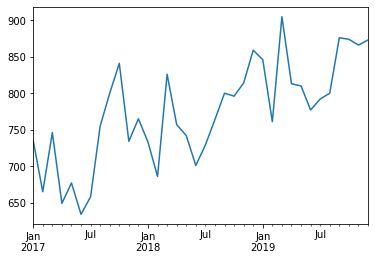

In [21]:
df_MODEL['óbitos'].plot()

Os dados apresentam uma tendência.

In [22]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.9MB/s 
     |████████████████████████████████| 9.5MB 34.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [23]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

adf_test(df_MODEL['óbitos'])


1. ADF :  -1.7189673362093527
2. P-Value :  0.4213673808947034
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression: 34
5. Critical Values :
	 1% :  -3.639224104416853
	 5% :  -2.9512301791166293
	 10% :  -2.614446989619377


De acordo com o ***p-Value***, podemos observar que nossos dados não são estacionários e teremiamos que transforma-los.

if p< 0.05 ; Dados estacionários

if p>0.05; Dados não são estacionários


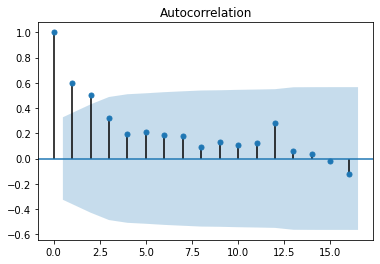

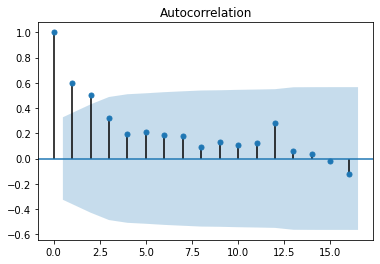

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_MODEL)

In [27]:
model_diff = df_MODEL.diff(periods=1)
model_diff = model_diff[1:36]
model_diff.head()

,óbitos
2017-02-01,-70.0
2017-03-01,81.0
2017-04-01,-97.0
2017-05-01,28.0
2017-06-01,-43.0


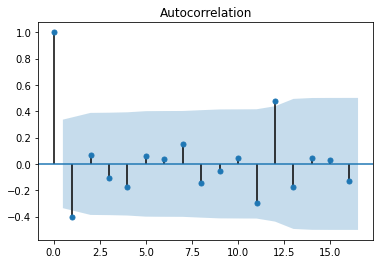

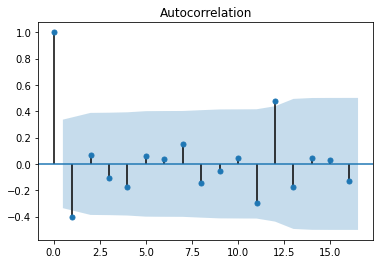

In [28]:
plot_acf(model_diff[1:36])

**A transformação gerou um modelo impreciso, desta forma deixamos os dados não estacionarios**

In [29]:
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


Com o decompose, podemos extrair tendências, sazonalidade e residuos

In [30]:
df_MODEL.óbitos

2017-01-01    735
2017-02-01    665
2017-03-01    746
2017-04-01    649
2017-05-01    677
2017-06-01    634
2017-07-01    658
2017-08-01    755
2017-09-01    800
2017-10-01    841
2017-11-01    734
2017-12-01    765
2018-01-01    733
2018-02-01    686
2018-03-01    826
2018-04-01    757
2018-05-01    742
2018-06-01    701
2018-07-01    729
2018-08-01    764
2018-09-01    800
2018-10-01    796
2018-11-01    814
2018-12-01    859
2019-01-01    846
2019-02-01    761
2019-03-01    905
2019-04-01    813
2019-05-01    810
2019-06-01    777
2019-07-01    792
2019-08-01    800
2019-09-01    876
2019-10-01    874
2019-11-01    866
2019-12-01    873
Name: óbitos, dtype: int64

In [31]:
decomposed = seasonal_decompose(df_MODEL, model='multiplicative')

In [32]:
trend = decomposed.trend
sazona = decomposed.seasonal
residual = decomposed.resid

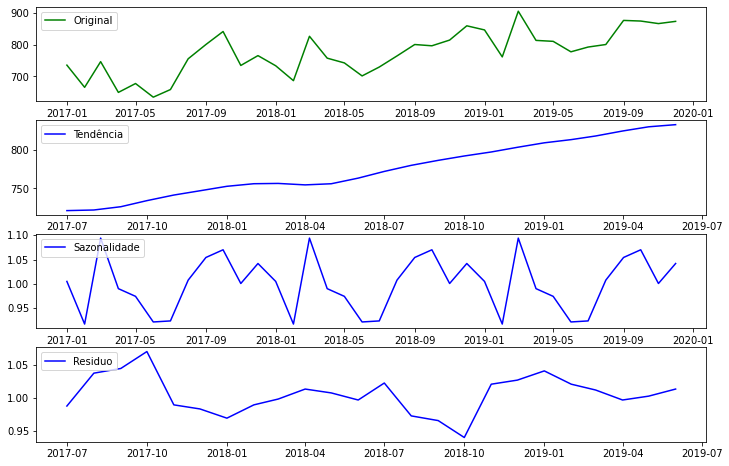

In [33]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_MODEL, label='Original', color = 'green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='Tendência', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sazona,label='Sazonalidade', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label='Residuo', color='blue')
plt.legend(loc='upper left')


#**Prevendo 2 primeiros meses de 2020**

---



In [123]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(df_MODEL.óbitos, order=(1,0, 2)) #p,d,q  p = número de periodos de tempo (intervalos) selecionados para o modelo autoregressivo
#d = Integrat (ordem integrada), 
#q = periodos de tempo na média movel 
results = model.fit()

In [124]:
predict = results.predict(0,35)

In [125]:
from sklearn import metrics
import numpy as np

print('Average error:',metrics.mean_absolute_error(df_MODEL.values, predict.values))
print('RMSE:',np.sqrt(metrics.mean_squared_error(df_MODEL.values, predict.values)))

Average error: 43.30442050629227
RMSE: 52.584865809050136


In [126]:
predict

2017-01-01    775.373078
2017-02-01    750.382931
2017-03-01    714.099782
2017-04-01    731.234350
2017-05-01    718.696345
2017-06-01    696.295025
2017-07-01    685.258748
2017-08-01    689.499776
2017-09-01    748.187553
2017-10-01    804.823690
2017-11-01    826.484857
2017-12-01    771.521570
2018-01-01    741.392777
2018-02-01    749.137671
2018-03-01    726.353564
2018-04-01    775.657246
2018-05-01    797.126251
2018-06-01    755.521493
2018-07-01    719.944301
2018-08-01    730.182824
2018-09-01    767.960508
2018-10-01    797.089048
2018-11-01    797.572931
2018-12-01    796.220086
2019-01-01    823.503926
2019-02-01    834.230014
2019-03-01    781.313708
2019-04-01    816.850108
2019-05-01    836.171012
2019-06-01    797.372709
2019-07-01    770.359950
2019-08-01    776.716051
2019-09-01    794.234046
2019-10-01    833.733659
2019-11-01    854.835751
2019-12-01    840.293987
Freq: MS, dtype: float64

In [150]:
predict = results.predict(0,37)

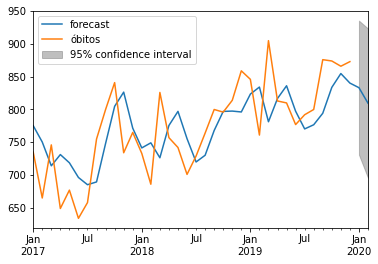

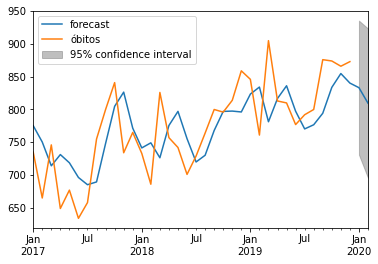

In [136]:
results.plot_predict(0,37) #(Inicio do plot, Fim do plot(datas a serem previstas))

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 óbitos   No. Observations:                   36
Model:                     ARMA(1, 0)   Log Likelihood                -195.392
Method:                       css-mle   S.D. of innovations             54.694
Date:                Thu, 01 Jul 2021   AIC                            396.784
Time:                        20:53:34   BIC                            401.535
Sample:                    01-01-2017   HQIC                           398.442
                         - 12-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          776.4063     23.240     33.408      0.000     730.857     821.955
ar.L1.óbitos     0.6241      0.131      4.773      0.000       0.368       0.880
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6023           +0.0000j            1.6023            0.0000
-----------------------------------------------------------------------------
"""

In [178]:
serie_model = df_MODEL.óbitos
serie_model

2017-01-01    735
2017-02-01    665
2017-03-01    746
2017-04-01    649
2017-05-01    677
2017-06-01    634
2017-07-01    658
2017-08-01    755
2017-09-01    800
2017-10-01    841
2017-11-01    734
2017-12-01    765
2018-01-01    733
2018-02-01    686
2018-03-01    826
2018-04-01    757
2018-05-01    742
2018-06-01    701
2018-07-01    729
2018-08-01    764
2018-09-01    800
2018-10-01    796
2018-11-01    814
2018-12-01    859
2019-01-01    846
2019-02-01    761
2019-03-01    905
2019-04-01    813
2019-05-01    810
2019-06-01    777
2019-07-01    792
2019-08-01    800
2019-09-01    876
2019-10-01    874
2019-11-01    866
2019-12-01    873
Name: óbitos, dtype: int64

In [185]:
fig = make_subplots( rows=1, cols=1)

#Col1
fig.add_trace(
       go.Line (
                 x=predict.index,y=predict ,name='Forecast',marker_color='#ED07CB '),row=1,col=1
        
        )

fig.add_trace(
    go.Line(
        x = serie_model.index, y=serie_model.values,name='Valores 2017-2019',marker_color='#2666FE  '), row=1, col=1

        )


# Update xaxis properties
fig.update_xaxes(title_text="Mês", row=1, col=1)



# Update yaxis properties
fig.update_yaxes(title_text="COUNT", row=1, col=1)



# Update title and height
fig.update_layout( title="MODELO DE PREVISÕES DE ÓBITOS ( JAN-FEV de 2020) ", height=800)

fig.show()
pyo.plot(fig)

'https://plotly.com/~psidata/68/'